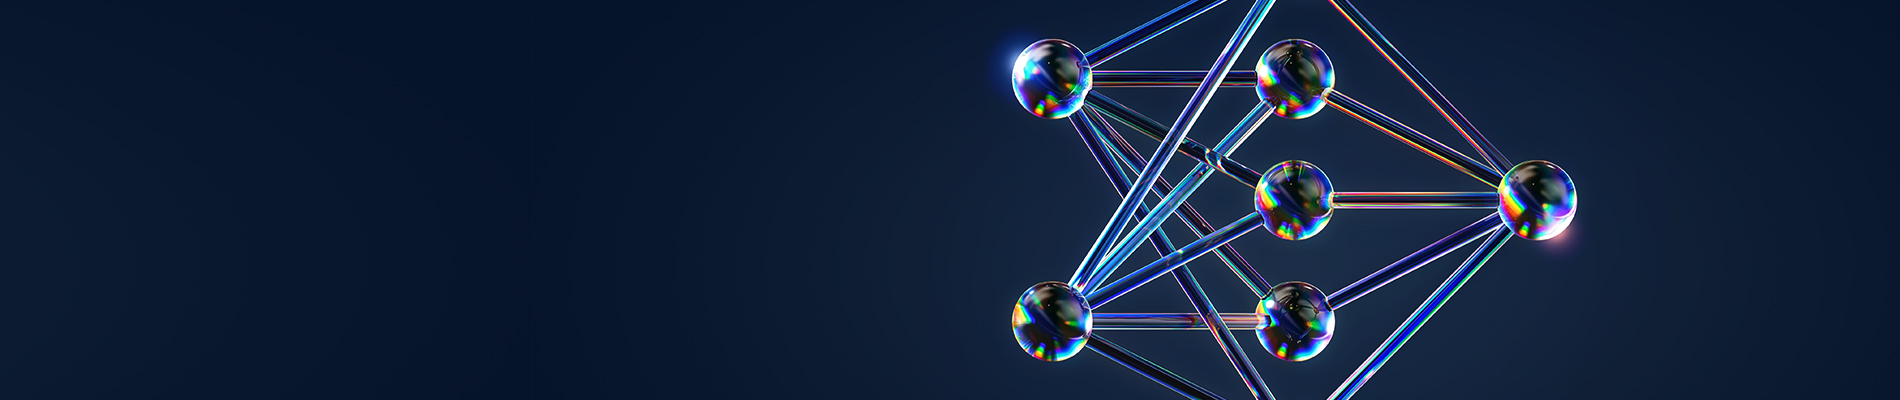

## Trading At The Close

Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. These closing prices serve as key indicators for investors, analysts and other market participants in evaluating the performance of individual securities and the market as a whole. Almost 10% of Nasdaq’s average daily volume occurs in the closing auction. Providing true price and size discovery, the closing auction determines benchmark pricing for index funds and other investment strategies.

In the last ten minutes of the Nasdaq exchange trading session, market makers like Optiver merge traditional order book trading with price auction data. This ability to consolidate information from both sources is critical for providing the best prices to all market participants.

We are excited to see how Kagglers approach this unique & challenging pricing problem!   

In this notebook we will cover:
- Financial concepts related to trading at the close
- Simple data exploration 
- Simple baseline model

### Auction
In financial markets, an auction is a mechanism for determining the price of a particular asset by allowing multiple buyers and sellers to interact directly in a controlled, regulated environment. There are many different kinds of auction, but for this competition we are particularly interested in the concept of a closing auction. 

In a closing auction, orders are collected over a pre-determined timeframe and then matched at a single price determined by the buy & sell demand expressed by auction participants. For Nasdaq Closing auctions, the exchange begins accepting orders at the start of the trading day and begins publishing the state of the auction book at 3:50pm ET for 10 minutes before the market closes at 4pm ET, at which point the orders are matched instantly at a single price. See below the timeline for Nasdaq closing auctions, taken from public documentation https://nasdaqtrader.com/content/ETFs/closing_cross_faqs.pdf.

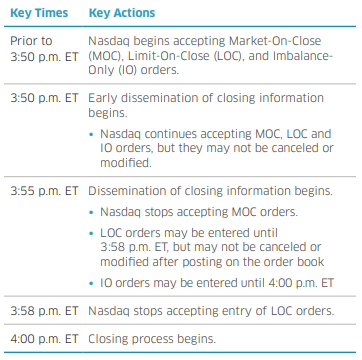

The closing price is determined as: The price at which the maximum number of shares can be ***matched***.
In the event the auction would have equal number of matched lots at different levels, Nasdaq uses a proprietary algorithm which takes into account the last traded price, the price-time priority of orders, and the available liquidity at different price levels. It is quite rare that the price at which the maximum shares can be matched is not unique. 

We will now dive deeper into the order book mechanics, and define some key terms such as the one italicised above.


### Order book

The term order book refers to an electronic list of buy (also known as bid) and sell (also known as ask) orders for a specific security or financial instrument organized by price level.

Below is a simple example of an order book in continuous (non-auction) trading. 
We can see that at a price level of 9 there are 2 shares on the bid, meaning the market participants are willing to buy 2 shares for a price of 9. Similarly we see that at a price level of 10 there is 1 share on the ask, meaning market participants are willing to sell 1 share for a price of 10.

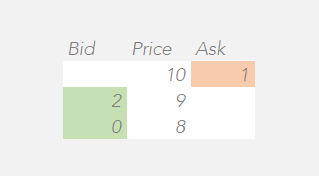

For this kind of order book in continuous trading, the highest bid price will always be less than the lowest ask price. For example, if someone were to put in an ask of 10 shares at a price of 9, then 2 shares would be ***matched*** since there is someone willing to buy 2 shares at a price of 9. The new best ask would be 8 shares at a price of 9, the new state of the book is displayed below.

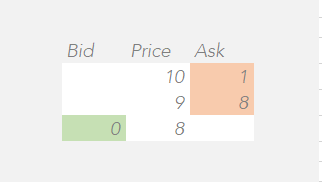

### Auction order book

The auction order book behaves slightly differently to the order book for continuous trading. In this book, the orders are not immediately matched, but instead collected until the moment the auction ends. You might notice in the example below that unlike the order book for continuous trading, the highest bid is not greater than the lowest ask. The book in the example below is referred to as ***in cross***, since the best bid and ask are overlapping. The closing auction price is therefore referred to as the ***uncross*** price, the price at which the shares which were in cross are matched.

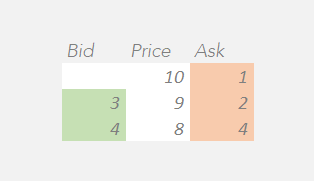

For the auction book example above, we can work through definitions for a few key terms. Suppose the auction uncrossed with the book in this state, then:
- At a price of 10, 0  lots would be matched since there as no bids >= 10.
- At a price of 9, 3 lots would be matched, as there are 3 bids >=9 and 6 asks <= 9.
- At a price of 8, 4 lots would be matched, since are 7 bids>=8, and there are 4 asks<=8.

So the price which maximises the number of matched lots would be 8.
We would therefore describe the auction order book in the following way:
- The uncross price is 8
- The matched size would be 4
- The ***imbalance*** would be 3 lots in the buy direction.

The term imbalance refers to the number of unmatched shares. At the uncross price of 8, there are 7 bids & 4 asks which can be matched, therefore we are left with 3 bids unmatched. Since bids are orders to buy, there is an imbalance of 3 lots in the buy direction.

The term ***far price*** refers to the hypothetical uncross price of the auction book, if it were to uncross at the reporting time. Nasdaq provides far price information 5 minutes before the closing cross. 

### Combined book

Combining the two books can result in a more accurate reflection of the market's buying and selling interest at different price levels. This aids in better price discovery, allowing the market to reach a more accurate and fair equilibrium price when the auction uncrosses.

Here we combine our original order book example & our auction book example by aggregating the buying & selling interest across all price levels.

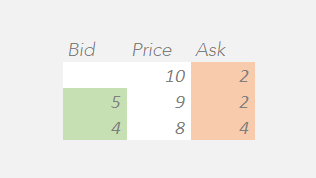

For this combined book:

- At a price of 10, 0 lots would be matched as there are no bids>=10.
- At a price of 9, 5 lots would be matched, as there are 5 bids>=9 and 6 asks <=9.
- At a price of 8, 4 lots would be matched, as there are 9 bids>=8 and 4 asks <=8. 

So, the price which maximizes matched lots would be the price of 9. We would therefore describe the combined order book in the following way:
- The uncross price is 9
- The matched size is 5
- The imbalance would be 1 lot, in the sell direction.
 
The hypothetical uncross price of combined book is called the ***near price***. Nasdaq provides near price information 5 minutes before the closing cross. 

Nasdaq also provides an indication of the fair price called the ***reference price***. The reference price is calculated as follows:
- If the near price is between the best bid and ask, then the reference price is equal to the near price
- If the near price > best ask, then reference price = best ask
- If the near price < best bid, then reference price = best bid
So the reference price is the near price bounded between the best bid and ask.



### Competition Data

In this competition, Kagglers are challenged to predict the short term price movements during the 10 minute auction period. All the training data is contained within a single train.csv file. Please refer to https://www.kaggle.com/competitions/optiver-trading-at-the-close/data & the introduction in this notebook for specific column definitions.

*   `stock_id` - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
*   `date_id` - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
*   `imbalance_size` - The amount unmatched at the current reference price (in USD).
*   `imbalance_buy_sell_flag` - An indicator reflecting the direction of auction imbalance.
    * buy-side imbalance; 1
    * sell-side imbalance; -1
    * no imbalance; 0
*   `reference_price` - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
*   `matched_size` - The amount that can be matched at the current reference price (in USD).
*   `far_price` - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
*   `near_price` - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
*   `[bid/ask]_price` - Price of the most competitive buy/sell level in the non-auction book.
*   `[bid/ask]_size` - The dollar notional amount on the most competitive buy/sell level  in the non-auction book.
*   `wap` - The weighted average price in the non-auction book. $$\frac{ {BidPrice * AskSize + AskPrice * BidSize}}{BidSize + AskSize} $$
*   `seconds_in_bucket` - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
*   `target` - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index.
    * The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
    * The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a  0.01% price move.
    * Where t is the time at the current observation, we can define the target:
$$ Target = (\frac{StockWAP_{t+60}}{StockWAP_{t}} - \frac{IndexWAP_{t+60}}{IndexWAP_{t}}) * 10000 $$

**All size related columns are in USD terms.**

**All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.**

In [5]:
import pandas as pd 
import numpy as np
import plotly.express as px

In [6]:
train = pd.read_csv('train.csv')
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


<AxesSubplot:title={'center':'Stock 0 on Day 0 - How the order book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

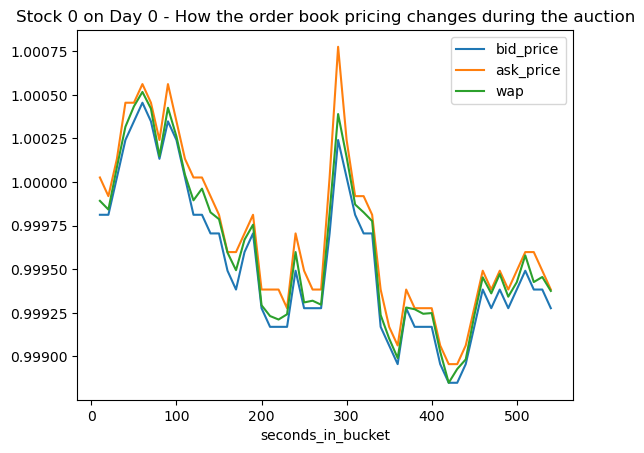

In [4]:
(
    train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','bid_price','ask_price', 'wap']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the order book pricing changes during the auction')
)

<AxesSubplot:title={'center':'Stock 0 on Day 0 - How the auction & combined book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

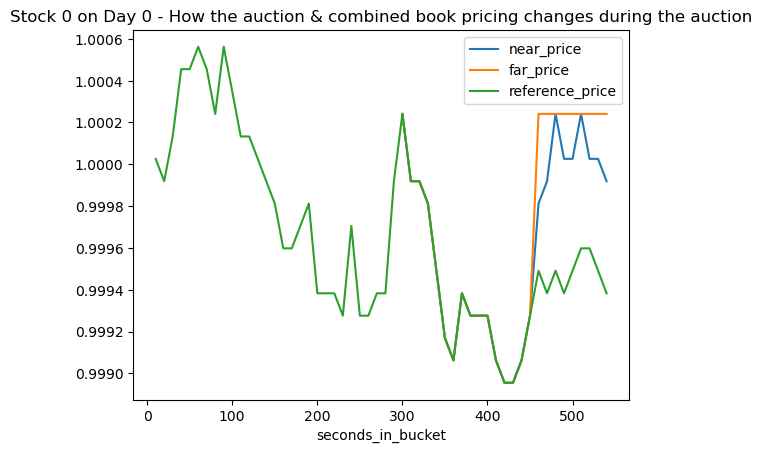

In [5]:
(
    train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','near_price','far_price','reference_price']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title = 'Stock 0 on Day 0 - How the auction & combined book pricing changes during the auction')
)

<AxesSubplot:title={'center':'Stock 0 on Day 0 - How the auction sizing changes during the auction period'}, xlabel='seconds_in_bucket'>

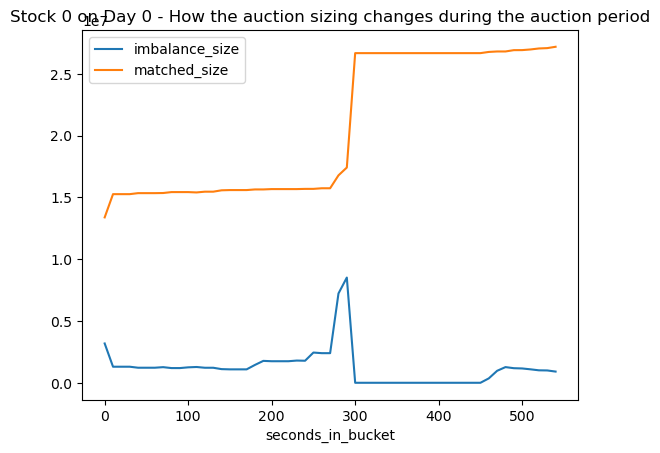

In [6]:
(
    train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','imbalance_size','matched_size']]
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the auction sizing changes during the auction period')
)

### Baseline Solutions
A simple baseline is to assume we have no valuable information about the direction any stock moves, which translates to a predicted value of 0 for all observations. This baseline is quite hard to beat in the context of financial markets.

However, we have some information in our dataset that should help us to beat this baseline. If we observe an auction imbalance, it indicates that at the current price there is buying or selling interest that will currently not get matched in the auction. We can therefore adjust our prediction upwards if there is a buy imbalance & downwards if there is a sell imbalance. 

In [7]:
simple_mapping = {
    1: 0.1,
    0: 0,
    -1: -0.1}

train['baseline_prediction'] = 0
train['simple_prediction'] = train['imbalance_buy_sell_flag'].map(simple_mapping)

### Evaluation
Our evaluation metric is Mean Absolute Error (MAE). The formula is given by:

$$ MAE =\frac{1}{n}\sum\limits_{i=1}^{n} {|y_i - x_i|} $$

Where:
-  n  is the total number of data points.
-  ${y_i}$ is the predicted value for the $i^{th}$ data point.
-  ${x_i}$ is the observed value for the $i^{th}$ data point. 

In [8]:
baseline_mae = (train['baseline_prediction'] - train['target']).abs().mean()
simple_prediction_mae = (train['simple_prediction'] - train['target']).abs().mean()

print(baseline_mae, simple_prediction_mae)
print('MAE improvement in basis points: ', (baseline_mae-simple_prediction_mae))

6.40777074811524 6.407056596608261
MAE improvement in basis points:  0.000714151506978844


In [7]:
# 🧹 Function to reduce memory usage of a Pandas DataFrame
from logging import Logger

def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    logger = Logger(name='reduce_mem_usage')
    
    # 📏 Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        logger.info(msg=f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(msg=f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(msg=f"Decreased by {decrease:.2f}%")

    # 🔄 Return the DataFrame with optimized memory usage
    return df

In [8]:
dataframe = reduce_mem_usage(train, verbose=True)

In [9]:
from sklearn.linear_model import LinearRegression

class DataProcessor():
    def __init__(self, df: pd.DataFrame, train_split = 0.75):
        self.train_split = train_split
        self.df = df 
        self.df.dropna()

    def add_square_versions_of_data(self):
        #add squares of the following columns: seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap
        self.df['seconds_in_bucket_squared'] = self.df['seconds_in_bucket'] ** 2
        self.df['imbalance_size_squared'] = self.df['imbalance_size'] ** 2
        self.df['imbalance_buy_sell_flag_squared'] = self.df['imbalance_buy_sell_flag'] ** 2
        self.df['reference_price_squared'] = self.df['reference_price'] ** 2
        self.df['matched_size_squared'] = self.df['matched_size'] ** 2
        self.df['far_price_squared'] = self.df['far_price'] ** 2
        self.df['near_price_squared'] = self.df['near_price'] ** 2
        self.df['bid_price_squared'] = self.df['bid_price'] ** 2
        self.df['bid_size_squared'] = self.df['bid_size'] ** 2
        self.df['ask_price_squared'] = self.df['ask_price'] ** 2
        self.df['ask_size_squared'] = self.df['ask_size'] ** 2
        self.df['wap_squared'] = self.df['wap'] ** 2

    def show_data(self):
        self.df.describe()

    def add_interactions(self):
        #add interaction variable for the imbalance size and the imbalance buy sell flag
        self.df['imbalance_interaction'] = self.df['imbalance_size'] * self.df['imbalance_buy_sell_flag']

    #basically take max(date), min(date) randomly select 25% of the dates to be test and the other 75% to be train
    def process_daily_data(self):
        mn_date = self.df['date_id'].min()
        mx_date = self.df['date_id'].max()

        #get the dates that will be used for testing
        dates = range(mn_date, mx_date + 1)
        test_dates = np.random.choice(dates, size = int(len(dates) * (1 - self.train_split)), replace = False)
        train_dates = [date for date in dates if date not in test_dates]

        #split the data into train and test
        self.train_df = self.df[self.df['date_id'].isin(train_dates)]
        self.test_df = self.df[self.df['date_id'].isin(test_dates)]

        #Z normalize the test 

        for col in self.df.columns:
            if col == 'target':
                continue
            self.df[col] = (self.df[col] - self.df[col].mean()) / self.df[col].std()


class SimpleLinearRegressor():
    def __init__(self, data_proccesor : DataProcessor, columns) -> None:
        self.data_processor = data_proccesor
        self.train_df = data_proccesor.train_df
        self.test_df = data_proccesor.test_df
        self.regressor_columns = columns


    def fit(self):
        self.model = LinearRegression()
        #linear models for the following columns: ,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap
        self.model.fit(self.train_df[self.regressor_columns], self.train_df['target'])
        
    def predict(self):
        self.test_df['prediction'] = self.model.predict(self.test_df[self.regressor_columns])
        return self.test_df

    def compute_MAE(self):
        self.test_df['error'] = self.test_df['target'] - self.test_df['prediction']
        return self.test_df['error'].abs().mean()


In [10]:
#give data to the data processor
data_processor = DataProcessor(dataframe, train_split=0.50)

data_processor.add_square_versions_of_data()
data_processor.add_interactions()
data_processor.process_daily_data()

KeyboardInterrupt: 

In [ ]:
data_processor.train_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,reference_price_squared,matched_size_squared,far_price_squared,near_price_squared,bid_price_squared,bid_size_squared,ask_price_squared,ask_size_squared,wap_squared,imbalance_interaction
16235,0,1,300,2644684.00,1,0.999601,11260473.0,1.018514,1.010132,0.999493,...,0.999202,1.267983e+14,1.037371,1.020367,0.998986,8.650860e+03,0.999202,42398328.0,0.998990,2644684.00
16236,1,1,300,0.00,0,1.000870,4947129.5,1.000870,1.000870,1.000870,...,1.001741,2.447409e+13,1.001741,1.001741,1.001741,4.508089e+08,1.002554,341430208.0,1.002175,0.00
16237,2,1,300,2157525.25,1,1.001194,7706838.5,1.041571,1.034574,1.000286,...,1.002389,5.939536e+13,1.084870,1.070343,1.000572,5.065197e+07,1.002496,4252545.0,1.002065,2157525.25
16238,3,1,300,9921457.00,1,0.999614,45065404.0,1.012260,1.010754,0.999442,...,0.999228,2.030891e+15,1.024670,1.021624,0.998884,1.214906e+09,0.999402,9130007.0,0.999360,9921457.00
16239,4,1,300,0.00,0,1.002404,18097482.0,1.002404,1.002404,1.002123,...,1.004814,3.275188e+14,1.004814,1.004814,1.004251,2.257748e+09,1.004814,224599696.0,1.004678,0.00


In [ ]:
data_processor.test_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,reference_price_squared,matched_size_squared,far_price_squared,near_price_squared,bid_price_squared,bid_size_squared,ask_price_squared,ask_size_squared,wap_squared,imbalance_interaction
5730,0,0,300,0.000000e+00,0,1.000241,26670118.00,1.000241,1.000241,1.000026,...,1.000482,7.112952e+14,1.000482,1.000482,1.000052,3.732358e+08,1.000482,2.608080e+08,1.000286,0.000000e+00
5731,1,0,300,2.423330e+05,-1,1.000073,3242054.25,0.981974,0.994490,0.999544,...,1.000146,1.051092e+13,0.964273,0.989010,0.999088,1.866706e+09,1.000616,4.172868e+06,1.000546,-2.423330e+05
5732,2,0,300,0.000000e+00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,...,1.000386,2.182175e+13,1.000386,1.000386,0.998071,3.598988e+08,1.002073,3.562689e+09,0.999036,0.000000e+00
5733,3,0,300,2.914730e+06,1,0.999870,41057776.00,1.003870,1.002279,0.999827,...,0.999740,1.685741e+15,1.007755,1.004563,0.999654,6.537994e+08,1.000084,1.436221e+09,0.999828,2.914730e+06
5734,4,0,300,3.396923e+06,1,0.998496,38356176.00,1.007894,1.007894,0.998357,...,0.996994,1.471196e+15,1.015850,1.015850,0.996717,2.086869e+08,0.997408,6.766137e+06,0.997302,3.396923e+06


In [ ]:
#given the data that we have provided; take that processed data and perform simplified linear regression on it 
regressor_cols = ['seconds_in_bucket','imbalance_size','imbalance_buy_sell_flag',
                  'reference_price','matched_size','far_price','near_price','bid_price',
                  'bid_size','ask_price','ask_size','wap',
                #   'seconds_in_bucket_squared','imbalance_size_squared','imbalance_buy_sell_flag_squared',
                #   'reference_price_squared','matched_size_squared','far_price_squared','near_price_squared',
                #   'bid_price_squared','bid_size_squared','ask_price_squared','ask_size_squared','wap_squared',
                  'imbalance_interaction']
simplified_linear_regressor = SimpleLinearRegressor(data_processor,regressor_cols)
#fit the model
simplified_linear_regressor.fit()
#make predictions
simplified_linear_regressor.predict()
#compute MAE
print(simplified_linear_regressor.compute_MAE())


5.6356177


/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_74697/1162395206.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_df['prediction'] = self.model.predict(self.test_df[self.regressor_columns])
/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_74697/1162395206.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_df['error'] = self.test_df['target'] - self.test_df['prediction']


In [ ]:
#XGBoost regressor

from sklearn.ensemble import RandomForestRegressor

class RandomForrest():
    def __init__(self, data_processor : DataProcessor, columns) -> None:
        self.data_processor = data_processor
        self.train_df = data_processor.train_df
        self.test_df = data_processor.test_df
        self.regressor_columns = columns
    
    def fit(self):
        self.model = RandomForestRegressor()
        self.model.fit(self.train_df[self.regressor_columns], self.train_df['target'])

    def predict(self):
        self.test_df['prediction'] = self.model.predict(self.test_df[self.regressor_columns])
        return self.test_df
    
    def compute_MAE(self):
        self.test_df['error'] = self.test_df['target'] - self.test_df['prediction']
        return self.test_df['error'].abs().mean()

In [ ]:
random_forrest_regressor = RandomForrest(data_processor, regressor_cols)
random_forrest_regressor.fit()
random_forrest_regressor.predict()
print(random_forrest_regressor.compute_MAE())

KeyboardInterrupt: 